In [2]:
import pandas as pd
import numpy as np
import os, glob

from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)

            category = file.parents[1].name  # DDoS, DoS, etc.
            attack = file.parent.name        # DDoS ICMP, DoS TCP, etc.
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'

            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class

            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

# Load train
train_root = Path('../../../Data/CICIoMT2024/train')
train_df = load_dataset_from_structure(train_root)

# Load test
test_root = Path('../../../Data/CICIoMT2024/test')
test_df = load_dataset_from_structure(test_root)

# Cek ringkasan
print("Train set:", train_df.shape)
print(train_df[['category', 'attack', 'class']].value_counts())
print("\nTest set:", test_df.shape)
print(test_df[['category', 'attack', 'class']].value_counts())


Train set: (7160831, 48)
category  attack              class 
DDoS      DDoS UDP            Attack    1635956
          DDoS ICMP           Attack    1537476
          DDoS TCP            Attack     804465
          DDoS SYN            Attack     801962
DoS       DoS UDP             Attack     566950
          DoS SYN             Attack     441903
          DoS ICMP            Attack     416292
          DoS TCP             Attack     380384
BENIGN    BENIGN              Benign     192732
MQTT      DDoS Connect Flood  Attack     173036
RECON     Port Scan           Attack      83981
MQTT      DoS Publish Flood   Attack      44376
          DDoS Publish Flood  Attack      27623
RECON     OS Scan             Attack      16832
SPOOFING  SPOOFING            Attack      16047
MQTT      DoS Connect Flood   Attack      12773
          Malformed Data      Attack       5130
RECON     Recon VulScan       Attack       2173
          Ping Sweep          Attack        740
Name: count, dtype: int64


In [12]:
# Gabungkan train dan test menjadi satu DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)
# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(df['class'])


# Fitur numerik + scaling
X = df.drop(['class', 'category', 'attack'], axis=1, errors='ignore').select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [13]:


models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),

    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
        n_estimators=100,
        algorithm='SAMME',
        random_state=42
    ),

    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        objective='multi:softmax',
        eval_metric='mlogloss',
        num_class=len(le.classes_),
        random_state=42
    ),

    'LightGBM': LGBMClassifier(
        objective='multiclass',
        num_class=len(le.classes_),
        random_state=42
    ),

    'CatBoost': CatBoostClassifier(
        verbose=0,
        iterations=100,
        depth=6,
        loss_function='MultiClass',
        random_seed=42
    ),

    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
}



===== Random Forest =====
              precision    recall  f1-score       support
Attack         0.999832  0.999569  0.999701  1.709052e+06
Benign         0.984138  0.993754  0.988923  4.595100e+04
accuracy       0.999417  0.999417  0.999417  9.994171e-01
macro avg      0.991985  0.996662  0.994312  1.755003e+06
weighted avg   0.999421  0.999417  0.999418  1.755003e+06


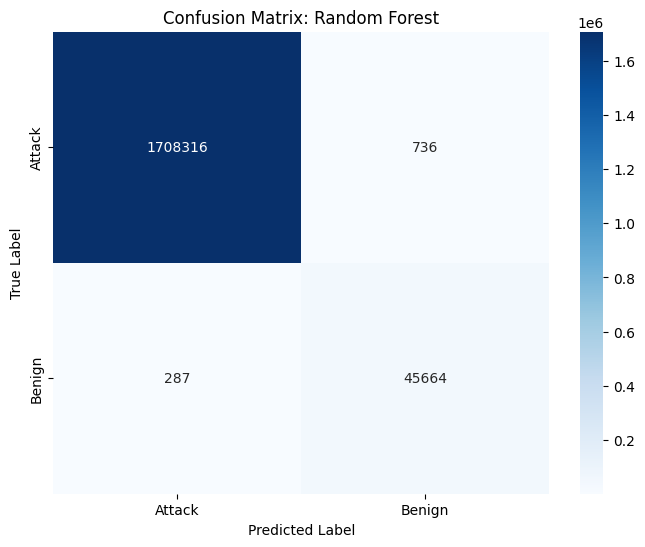


===== AdaBoost =====
              precision    recall  f1-score       support
Attack         0.999979  0.997785  0.998881  1.709052e+06
Benign         0.923826  0.999238  0.960054  4.595100e+04
accuracy       0.997823  0.997823  0.997823  9.978228e-01
macro avg      0.961903  0.998512  0.979467  1.755003e+06
weighted avg   0.997986  0.997823  0.997864  1.755003e+06


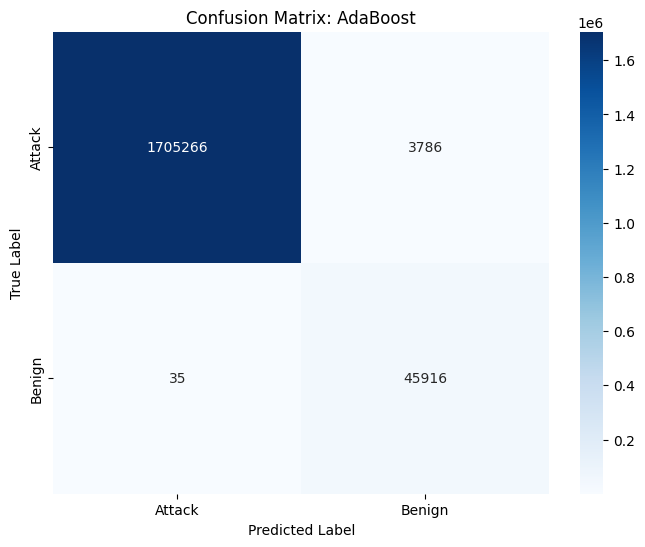


===== XGBoost =====


C:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:22:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score       support
Attack         0.999787  0.999430  0.999608  1.709052e+06
Benign         0.979060  0.992079  0.985526  4.595100e+04
accuracy       0.999237  0.999237  0.999237  9.992370e-01
macro avg      0.989424  0.995754  0.992567  1.755003e+06
weighted avg   0.999244  0.999237  0.999239  1.755003e+06


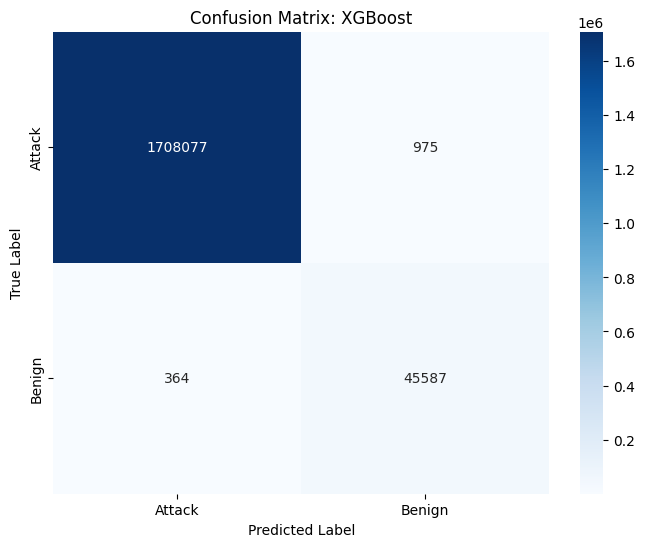


===== LightGBM =====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.389167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 7020010, number of used features: 44
[LightGBM] [Info] Start training from score -0.026617
[LightGBM] [Info] Start training from score -3.639478
              precision    recall  f1-score       support
Attack         0.999759  0.999368  0.999564  1.709052e+06
Benign         0.976834  0.991056  0.983893  4.595100e+04
accuracy       0.999150  0.999150  0.999150  9.991504e-01
macro avg      0.988297  0.995212  0.991729  1.755003e+06
weighted avg   0.999159  0.999150  0.999153  1.755003e+06


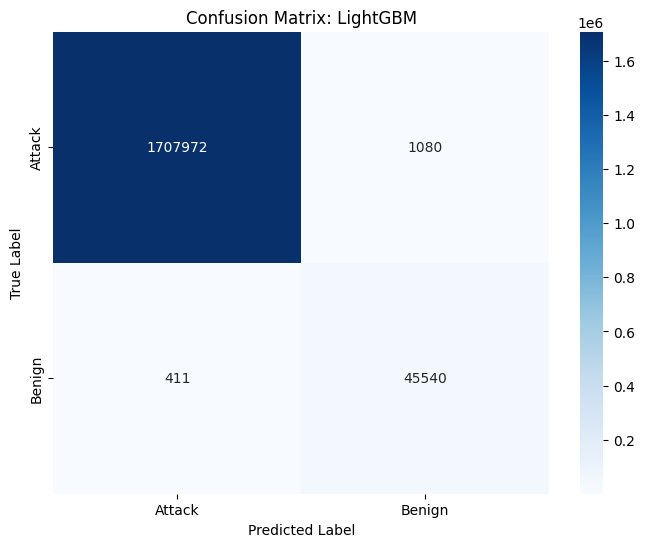


===== CatBoost =====


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score       support
Attack         0.999742  0.999316  0.999529  1.709052e+06
Benign         0.974957  0.990403  0.982619  4.595100e+04
accuracy       0.999083  0.999083  0.999083  9.990826e-01
macro avg      0.987349  0.994859  0.991074  1.755003e+06
weighted avg   0.999093  0.999083  0.999086  1.755003e+06


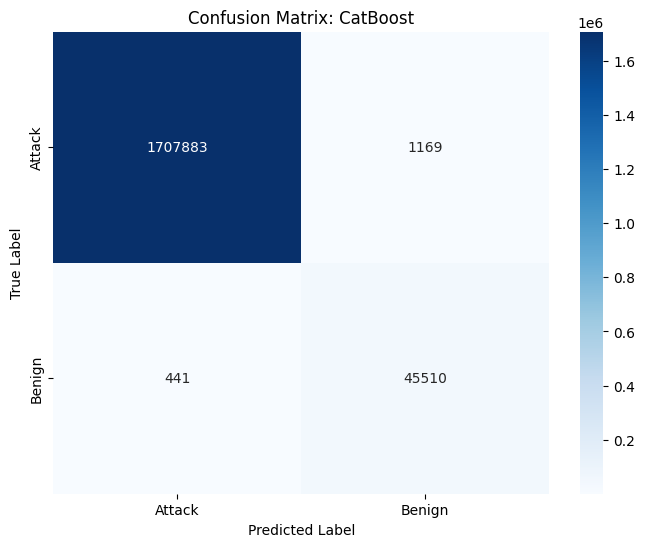


===== Extra Trees =====
              precision    recall  f1-score       support
Attack         0.999788  0.999523  0.999655  1.709052e+06
Benign         0.982415  0.992100  0.987234  4.595100e+04
accuracy       0.999328  0.999328  0.999328  9.993282e-01
macro avg      0.991101  0.995811  0.993445  1.755003e+06
weighted avg   0.999333  0.999328  0.999330  1.755003e+06


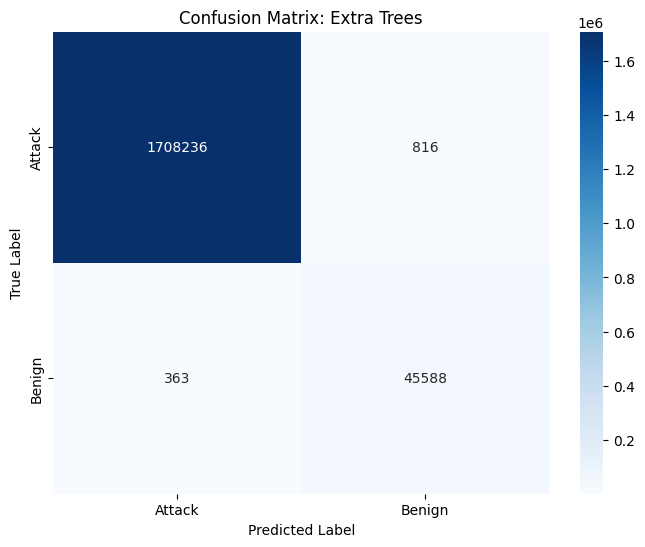

In [16]:
results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Inverse ke label asli
    y_pred_labels = le.inverse_transform(y_pred)
    y_true_labels = le.inverse_transform(y_test)

    # Classification Report
    report = classification_report(
        y_true_labels, y_pred_labels, digits=5,
        output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    results[name] = {
        'report': report_df,
        'confusion_matrix': cm
    }


In [17]:
performance_data = []

for name, result in results.items():
    report = result['report']
    accuracy = report.loc['accuracy']['precision'] if 'accuracy' in report.index else None
    macro = report.loc['macro avg']
    performance_data.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Macro Avg)': macro['precision'],
        'Recall (Macro Avg)': macro['recall'],
        'F1-Score (Macro Avg)': macro['f1-score']
    })

performance_df = pd.DataFrame(performance_data)
performance_df.sort_values(by='F1-Score (Macro Avg)', ascending=False, inplace=True)
performance_df.reset_index(drop=True, inplace=True)
display(performance_df)


,Model,Accuracy,Precision (Macro Avg),Recall (Macro Avg),F1-Score (Macro Avg)
0,Random Forest,0.999417,0.991985,0.996662,0.994312
1,Extra Trees,0.999328,0.991101,0.995811,0.993445
2,XGBoost,0.999237,0.989424,0.995754,0.992567
3,LightGBM,0.999150,0.988297,0.995212,0.991729
4,CatBoost,0.999083,0.987349,0.994859,0.991074
5,AdaBoost,0.997823,0.961903,0.998512,0.979467


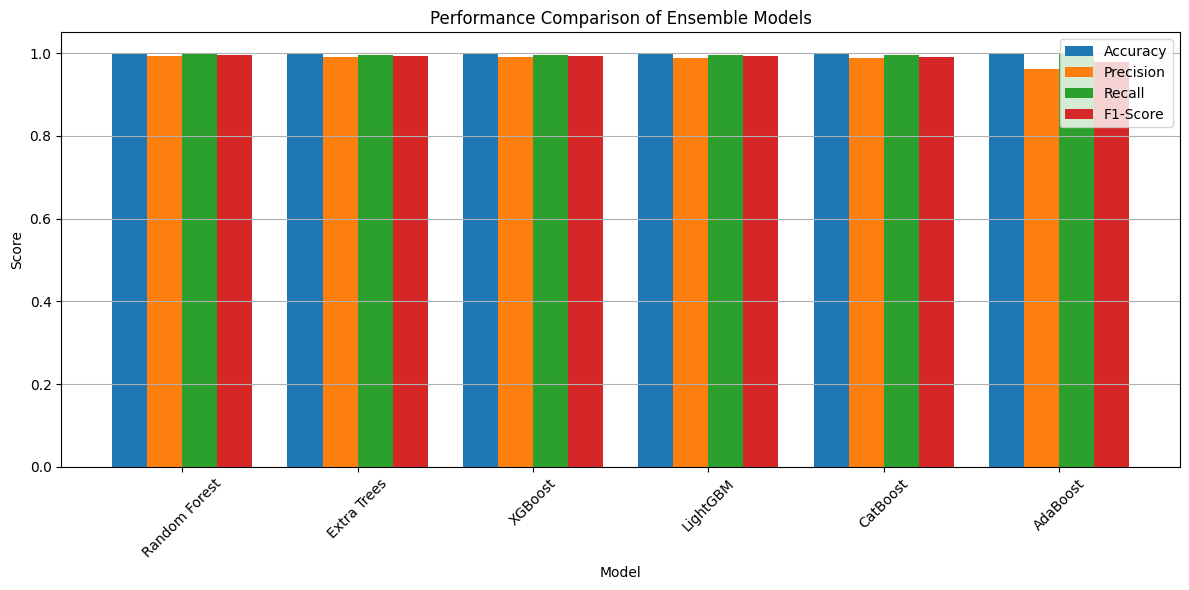

In [18]:
bar_width = 0.2
index = np.arange(len(performance_df))

plt.figure(figsize=(12, 6))
plt.bar(index, performance_df['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, performance_df['Precision (Macro Avg)'], bar_width, label='Precision')
plt.bar(index + 2*bar_width, performance_df['Recall (Macro Avg)'], bar_width, label='Recall')
plt.bar(index + 3*bar_width, performance_df['F1-Score (Macro Avg)'], bar_width, label='F1-Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Comparison of Ensemble Models')
plt.xticks(index + 1.5 * bar_width, performance_df['Model'], rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()
